In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [2]:
data_dir= './leapgestrecog/leapGestRecog/00/'

### Defining a lookup dictionary for gesture labels and prepares data for training.

In [3]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir(data_dir):
    if not j.startswith('.'): # If running this code locally, this is to 
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'01_palm': 0,
 '02_l': 1,
 '03_fist': 2,
 '04_fist_moved': 3,
 '05_thumb': 4,
 '06_index': 5,
 '07_ok': 6,
 '08_palm_moved': 7,
 '09_c': 8,
 '10_down': 9}

### Data preprocessing

In [4]:
x_data = []
y_data = []
IMG_SIZE = 150
datacount = 0 # We'll use this to tally how many images are in our dataset
for i in range(0, 10): # Loop over the ten top-level folders
    for j in os.listdir('./leapgestrecog/leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir('./leapgestrecog/leapGestRecog/0' + 
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                path = './leapgestrecog/leapGestRecog/0' + str(i) + '/' + j + '/' + k
                img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1) 

### plotting our data

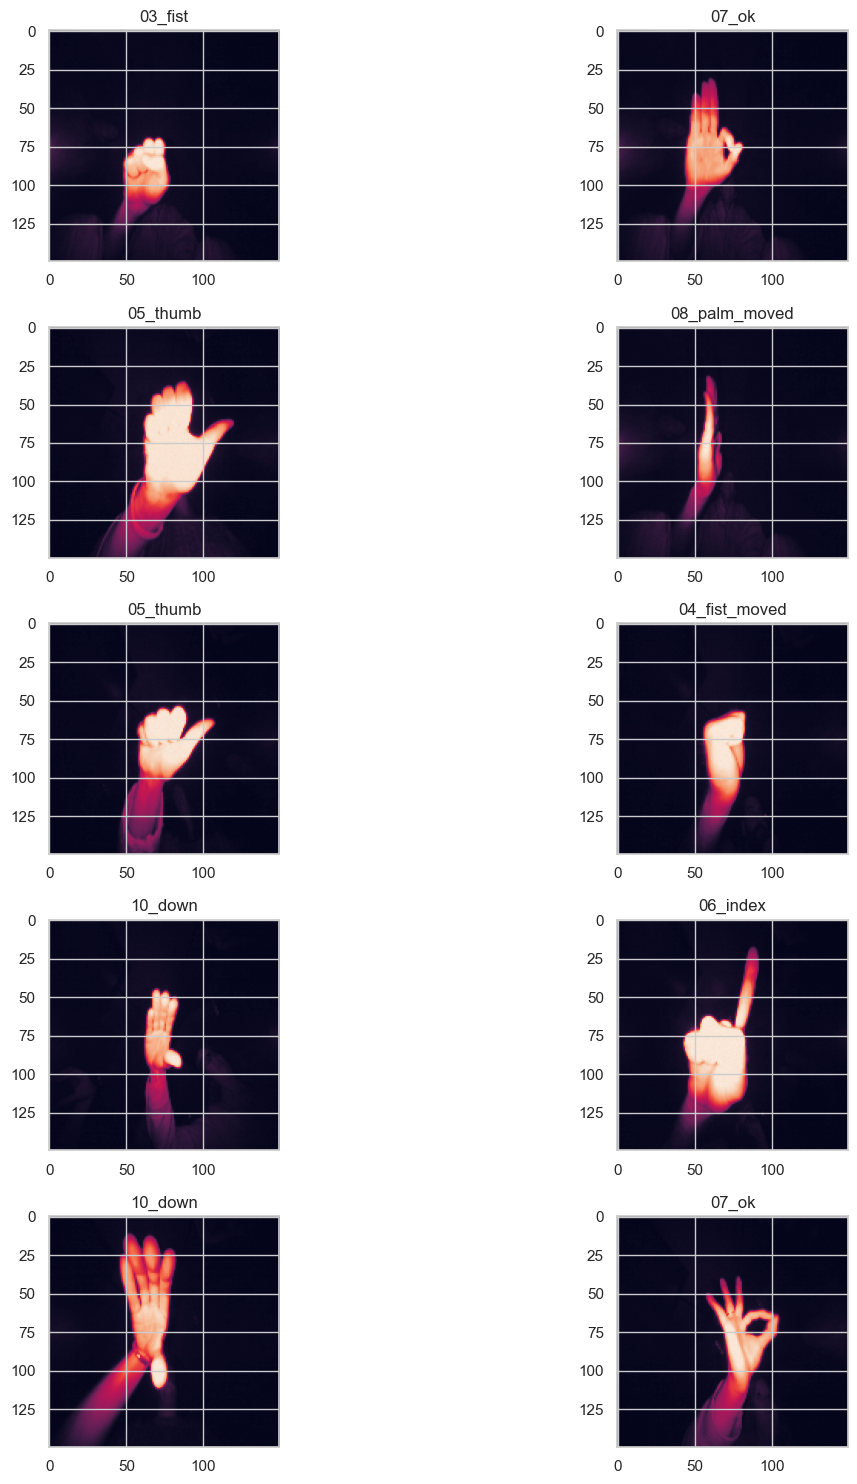

In [5]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(y_data))
        ax[i,j].imshow(x_data[l])
        ax[i,j].set_title(reverselookup[y_data[l,0]])
        
plt.tight_layout()

### Data encoding

In [6]:
y_data=to_categorical(y_data)
x_data = x_data.reshape((datacount, IMG_SIZE, IMG_SIZE, 1))
x_data = x_data/255

### Splits the dataset into training and testing sets

In [7]:
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.25,random_state=42)

### Building a CNN model architecture using Keras layers.

In [8]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10, activation = "softmax"))

In [9]:
batch_size=128
epochs=10

### Defines callbacks for model training

In [10]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

### Compiles the model with an optimizer, loss function, and metrics.

In [11]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 96)       0

### Training our model

In [13]:
History = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test),callbacks=callbacks)

Epoch 1/10
118/118 [==============================] - ETA: 0s - loss: 0.3458 - accuracy: 0.8852 
Epoch 1: val_loss improved from inf to 0.00982, saving model to .\base.model


INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


118/118 [==============================] - 2008s 17s/step - loss: 0.3458 - accuracy: 0.8852 - val_loss: 0.0098 - val_accuracy: 0.9976 - lr: 0.0010
Epoch 2/10
118/118 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9963 
Epoch 2: val_loss improved from 0.00982 to 0.00022, saving model to .\base.model


INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


118/118 [==============================] - 2103s 18s/step - loss: 0.0122 - accuracy: 0.9963 - val_loss: 2.1794e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/10
118/118 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.9998 
Epoch 3: val_loss improved from 0.00022 to 0.00021, saving model to .\base.model


INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


118/118 [==============================] - 1628s 14s/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 2.0537e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/10
118/118 [==============================] - ETA: 0s - loss: 1.0726e-04 - accuracy: 1.0000 
Epoch 4: val_loss improved from 0.00021 to 0.00001, saving model to .\base.model


INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


118/118 [==============================] - 1457s 12s/step - loss: 1.0726e-04 - accuracy: 1.0000 - val_loss: 1.4016e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/10
118/118 [==============================] - ETA: 0s - loss: 1.3080e-05 - accuracy: 1.0000 
Epoch 5: val_loss improved from 0.00001 to 0.00001, saving model to .\base.model


INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


118/118 [==============================] - 1439s 12s/step - loss: 1.3080e-05 - accuracy: 1.0000 - val_loss: 9.8208e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/10
118/118 [==============================] - ETA: 0s - loss: 8.8647e-06 - accuracy: 1.0000 
Epoch 6: val_loss improved from 0.00001 to 0.00001, saving model to .\base.model


INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


118/118 [==============================] - 1465s 12s/step - loss: 8.8647e-06 - accuracy: 1.0000 - val_loss: 7.7121e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/10
118/118 [==============================] - ETA: 0s - loss: 6.7293e-06 - accuracy: 1.0000 
Epoch 7: val_loss improved from 0.00001 to 0.00001, saving model to .\base.model


INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
118/118 [==============================] - 1512s 13s/step - loss: 6.7293e-06 - accuracy: 1.0000 - val_loss: 6.3262e-06 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 8/10
118/118 [==============================] - ETA: 0s - loss: 5.6590e-06 - accuracy: 1.0000 
Epoch 8: val_loss improved from 0.00001 to 0.00001, saving model to .\base.model


INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


118/118 [==============================] - 1498s 13s/step - loss: 5.6590e-06 - accuracy: 1.0000 - val_loss: 6.2213e-06 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 9/10
118/118 [==============================] - ETA: 0s - loss: 5.5163e-06 - accuracy: 1.0000 
Epoch 9: val_loss improved from 0.00001 to 0.00001, saving model to .\base.model


INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets


118/118 [==============================] - 1484s 13s/step - loss: 5.5163e-06 - accuracy: 1.0000 - val_loss: 6.1071e-06 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 10/10
118/118 [==============================] - ETA: 0s - loss: 5.3697e-06 - accuracy: 1.0000 
Epoch 10: val_loss improved from 0.00001 to 0.00001, saving model to .\base.model


INFO:tensorflow:Assets written to: .\base.model\assets


INFO:tensorflow:Assets written to: .\base.model\assets



Epoch 10: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
118/118 [==============================] - 1801s 15s/step - loss: 5.3697e-06 - accuracy: 1.0000 - val_loss: 5.9832e-06 - val_accuracy: 1.0000 - lr: 1.0000e-04


### Plots and displays the training and validation loss and accuracy over epochs

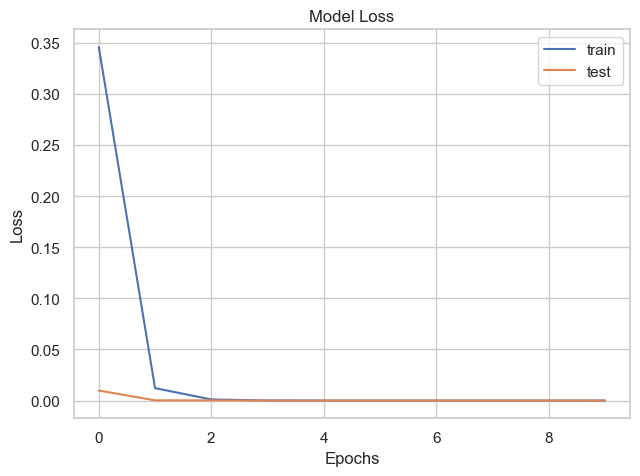

In [14]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

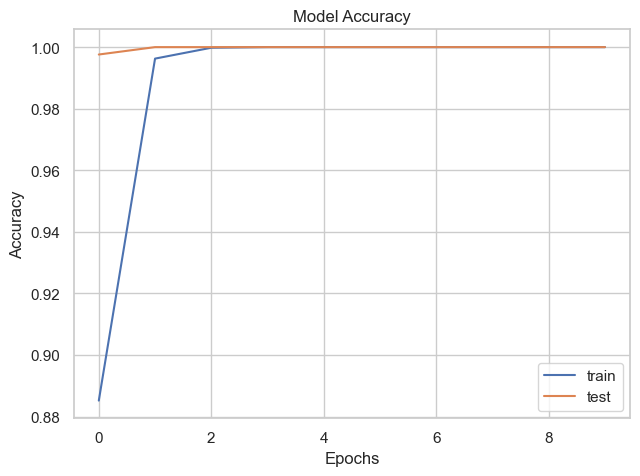

In [15]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()